_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Aakarsh Nair, Andreas Kotzur, Ahmed Eldably</span>

LLM Disclaimer: <span style='background: yellow'>
Google Gemini, Open AI 4o , Google Gemini Diffiusion - Planning, Coding, and Verification.</span>

# Coding Lab 8: Neural Morphologies

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

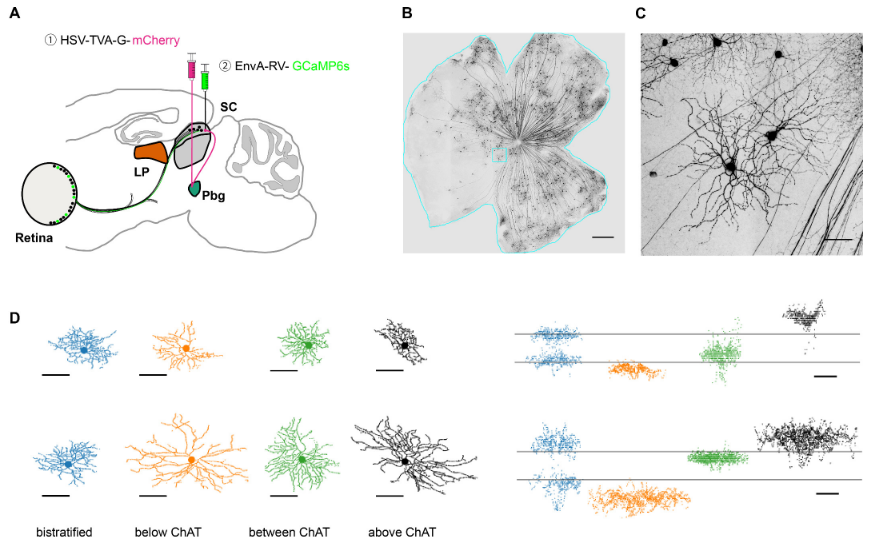

### 1. Data

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nds_cl_8.zip` from ILIAS and unzip it in a subfolder `../data/`


### 2. Toolbox

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. We recommend to use the Github version, as it is more up-to-date:

```
git clone https://github.com/berenslab/MorphoPy
pip install -e MorphoPy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [11]:
import pandas as pd
import numpy as np
import os


from morphopy.neurontree import NeuronTree as nt

from morphopy.computation import file_manager
from morphopy.computation import file_manager as fm
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings

warnings.filterwarnings("ignore")

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearnv

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-20 15:50:03CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

sklearnv: not installed

seaborn   : 0.13.2
matplotlib: 3.9.4
numpy     : 1.26.4
pandas    : 2.2.3
morphopy  : 0.7.2

Watermark: 2.5.0



In [5]:
plt.style.use("../matplotlib_style.txt")

# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [16]:
def load_swc(filepath: str) -> pd.DataFrame:
    """Loads in the swc located at filepath as a pandas dataframe.

    Args:
        filepath (str): The path to the swc file.

    Returns:
        pd.DataFrame: A pandas dataframe containing the swc file.
    """
    swc = pd.read_csv(
        filepath,
        delim_whitespace=True,
        comment="#",
        names=["n", "type", "x", "y", "z", "radius", "parent"],
        index_col=False,
    )
    return swc


# define color for each cluster
colors = sns.color_palette("rainbow_r", n_colors=14)

In [17]:
# import swc file
PATH = "../data/nds_cl_8/"
data_path = PATH + "reconstructions/soma-centered/"
filename = "0006_00535_4L_C02_01.swc"
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.00,0.00,0.47,1.0,-1
1,2,3,-0.03,0.00,0.47,1.0,1
2,3,3,0.17,-0.08,0.51,1.0,1
3,4,3,0.24,-0.31,0.38,1.0,3
4,5,3,0.02,0.14,0.42,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [18]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels["cluster"], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

Noted, by default, the `file_manager` loads data with `pca_rot=True` and `soma_center=True`. For the all the exercise in this Coding Lab, it's better to set both of them as `False`. 

*Grading: 2pts*

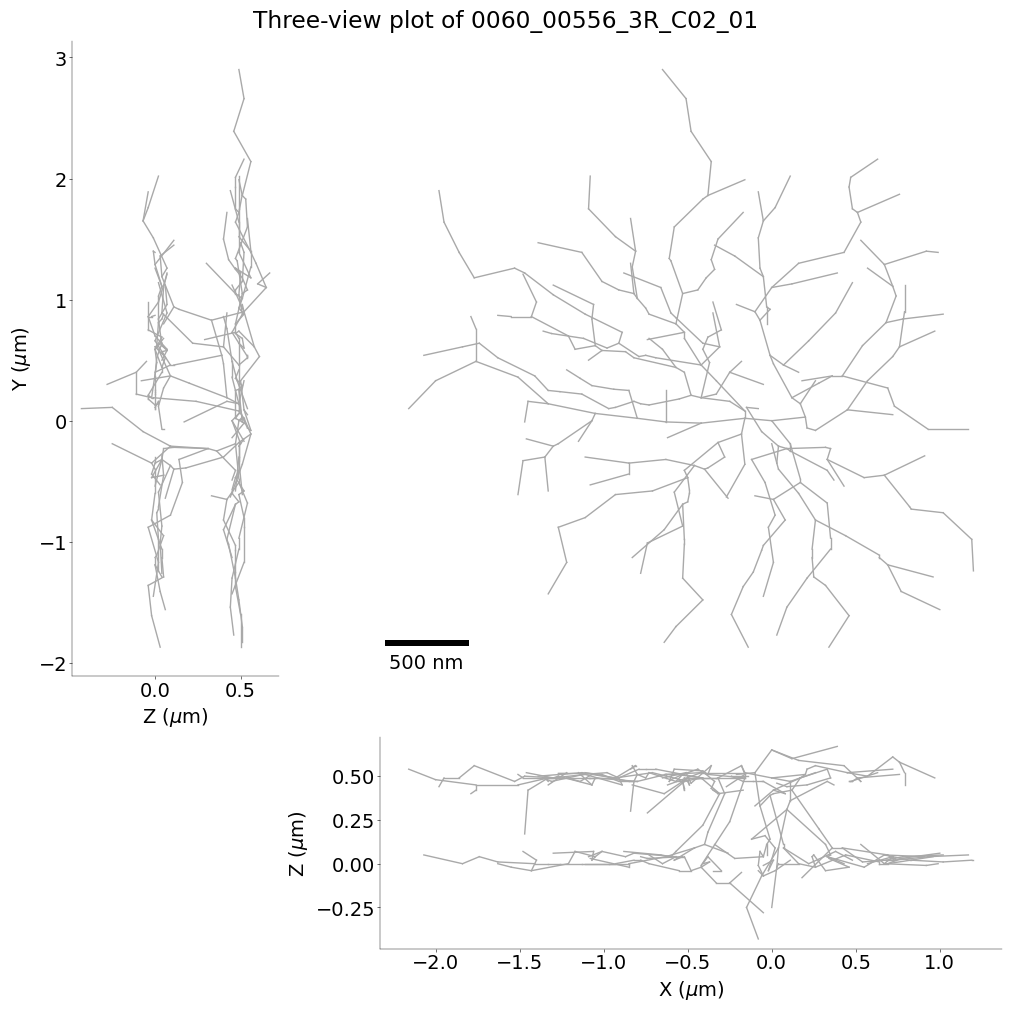

In [19]:
# ----------------------------------------------------------------
# load the example cell "0060_00556_3R_C02_01" with `file_manager`
# from morphology (0.5 pts)
# ----------------------------------------------------------------

data_path = "../data/nds_cl_8/reconstructions/soma-centered/"
inspected_neuron = "0060_00556_3R_C02_01"
neuron_path = data_path + f"{inspected_neuron}.swc"
neuron = fm.load_swc_file(neuron_path, soma_center=False, pca_rot=False)

# -------------------------------------
# plot all three planar views (0.5 pts)
# -------------------------------------
fig = plt.figure(figsize=(10, 10))
show_threeview(neuron, fig)
plt.suptitle(f"Three-view plot of {inspected_neuron}")  # Add a title
plt.show()

### Questions (0.5 pts)

1) Describe the dendritic structure of this neuron. How is it special? Can you even give a technical term for its appearance?

**Answer:**
The dendritic structure of this neuron is characterized by a roughly symmetrical, radial dendritic field in the top-down (XY) view, with branches extending outwards from a central point.

What makes this neuron special is its very precise stratification pattern, which is clearly visible in the side views (the XZ and YZ plots). The dendrites are not spread out continuously but are sharply segregated into two distinct, parallel layers along the Z-axis, which represents the depth in the retina.

The technical term for this dual-layered appearance is bi-stratified.

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [27]:
# load all reconstructions. Note: files are sorted by cell number
def load_files(path: str) -> list[nt]:
    """Returns list of NeuronTrees for all .swc files in `path`.
    The reconstructions should be sorted ascendingly by their filename.

    Args:
        path (str): The path to the folder containing the reconstructions.

    Returns:
        list[nt]: An object array of NeuronTrees containing all reconstructions at `path`.
    """
    neurons = []
    # ----------------------------------------------------------
    # use `file_manager` to import all reconstructions (0.5 pts)
    # Note the list should be sorted by filename.
    # ----------------------------------------------------------
    # 1. Find all swc files in the directory
    files = os.listdir(path)
    print(f"Found {len(files)} files in {path}")
    # 2. Filter for swc files
    files = [f for f in files if f.endswith(".swc")]
    files.sort()  # Sort files by filename
    for file in files:
        neuron = fm.load_swc_file(f"{path}/{file}", soma_center=False, pca_rot=False)
        neurons.append(neuron)
    return neurons


neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Found 550 files in ../data/nds_cl_8/reconstructions/soma-centered/
Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 4pts*

First, let's compute the feature-based representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics.


In [ ]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics

# --------------------------------------------------------------------------
# 1. extraction the morphometric statistics for the entire data set (0.5 pts)
# --------------------------------------------------------------------------
ms_list = [compute_morphometric_statistics(neuron) for neuron in neurons]

# -----------------------------------------------------------------------------------
# 2. concatenate data into one pd.DataFrame and set the `Cell_nr`` as index (0.5 pts)
# -----------------------------------------------------------------------------------
morphometric_statistics = pd.concat(ms_list, axis=0)
morphometric_statistics.reset_index(inplace=True)
morphometric_statistics.index.name = "Cell_nr"

Now let's visualize the data.

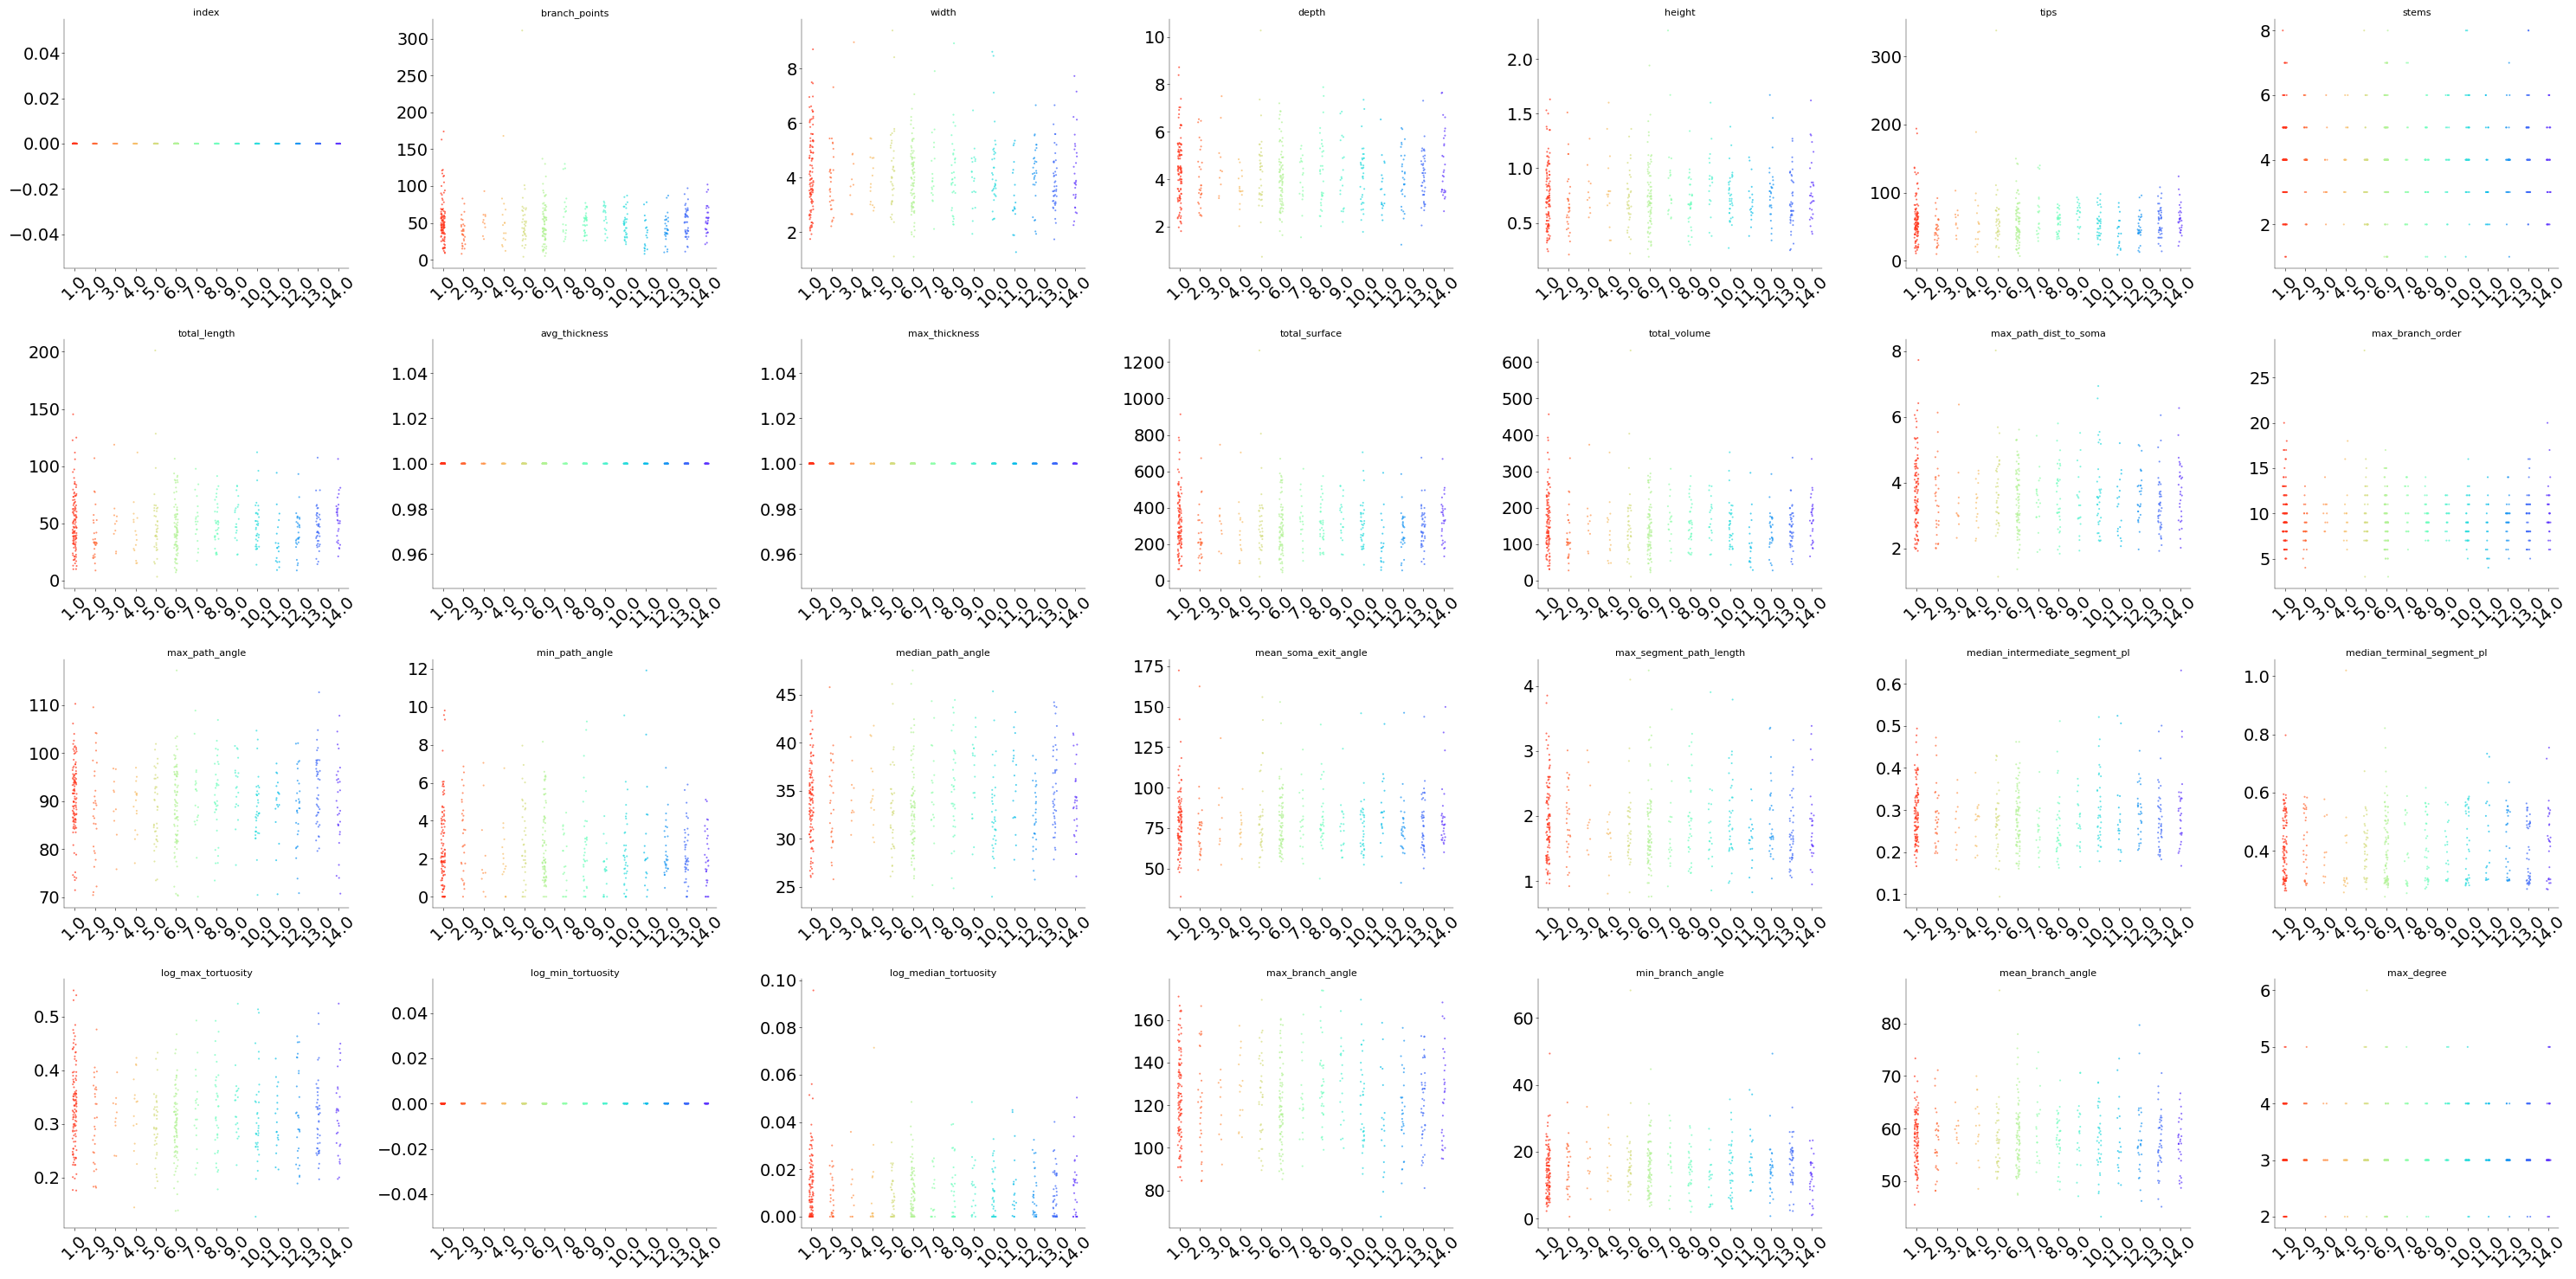

In [110]:
features = morphometric_statistics.columns.values

fig, axes = plt.subplots(4, 7, figsize=(30, 15))
axes = axes.flatten()

# -----------------------------------------------------------
# Create a scatter/strip plot for each morphometric statistic
# showing how it varies across clusters. (2 pts)
# -----------------------------------------------------------
for feature, ax in zip(features, axes):
    # Use seaborn's stripplot to show the distribution for each cluster
    sns.stripplot(
        x=labels["cluster"],  # Categorical data for the x-axis
        y=morphometric_statistics[feature],  # Numerical data for the y-axis
        ax=ax,  # Tell seaborn which subplot to draw on
        palette=colors,  # Use the predefined color palette
        s=3,  # Make the points a bit smaller to avoid overplotting
        alpha=0.7,  # Add some transparency
    )
    # Set the title of the subplot to the name of the feature
    ax.set_title(feature, fontsize=8)
    ax.set_xlabel("")  # Hide x-axis label for cleanliness
    ax.set_ylabel("")  # Hide y-axis label for cleanliness
    ax.tick_params(axis="x", rotation=45)  # Rotate cluster labels slightly

# Improve the layout to prevent titles from overlapping
plt.tight_layout()
plt.show()

In [115]:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder


# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_statistics - morphometric_statistics.mean()
) / morphometric_statistics.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

feature_names_morpho = morphometric_statistics.columns.tolist()
y = labels["cluster"].values
y_encoded = LabelEncoder().fit_transform(y)

# Calculate ANOVA F-test scores.
# f_classif returns F-statistics and p-values. We only need the F-stats.
f_scores, p_values = f_classif(morphometric_data, y_encoded)

# Calculate Mutual Information scores
mi_scores = mutual_info_classif(morphometric_data, y_encoded, random_state=17)

# Create a new DataFrame to store the results
informativeness_df = pd.DataFrame(
    {
        "Feature": feature_names_morpho,
        "ANOVA_F_Statistic": f_scores,
        "Mutual_Information": mi_scores,
    }
)

# Sort the DataFrame by the F-statistic in descending order
# to see the most informative features at the top.
informativeness_df = informativeness_df.sort_values(
    by="ANOVA_F_Statistic", ascending=False
).reset_index(drop=True)


# Display the final table
print("Feature Informativeness Table")
print("-----------------------------")
print(informativeness_df)

Feature Informativeness Table
-----------------------------
                           Feature  ANOVA_F_Statistic  Mutual_Information
0                            width          22.453216            0.250916
1                           height          19.792955            0.224896
2                            depth          18.332633            0.215494
3                     total_length          16.222915            0.243604
4                    total_surface          16.222915            0.243604
5                     total_volume          16.222915            0.243604
6            max_path_dist_to_soma          15.360768            0.197396
7                mean_branch_angle          13.763381            0.124881
8                median_path_angle          12.680239            0.092306
9          max_segment_path_length          10.190192            0.152162
10              log_max_tortuosity          10.023280            0.177667
11  median_intermediate_segment_pl           9.47256

### Questions (1 pt)

1) Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features)

**Answer:**

We find that the statistics *avg_thickness*, *max_thickness*, *log_min_tortuosity* do not  show a clear separation as values cluster around fixed values accorss the clusters. Computing the ANOVA_F_Statistic and mutual information, we find that these features are some of the least informative. Thus these 
can be removed as being uninformative in distinguishing the clusters. Additionally width, height, depth, and total_length are the most important statistics for 
distinguishing between the clusters.


2) More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain.

**Answer:**
Morphostatustics, give us a good summary statistic and a starting point for quick classification. The downside is that that they may miss an key feature 
of the neuron or might mask an underlying important geometric features. 



## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- `distance`: (default=1, in microns) determines the resampling distance.
- `bin_size`: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- `n_bins_x/y/z`: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- `density`: (default=True) bool to specify if a density or counts are returned.
- `smooth`: (default=True) bool to trigger Gaussian smoothing.
- `sigma`: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- `r_min_x/y/z`: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- `r_max_x/y/z`: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 4pts*

In [35]:
# For further analysis we will remove uninformative features and z-score along each statistic
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
morphometric_data = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (
    morphometric_data - morphometric_data.mean()
) / morphometric_data.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

In [ ]:
# ------------------------------------------------------------------------------------
# Find the minimal and maximal x,y,z - coordinates of the reconstructions to normalize
# the density maps globally using r_min_x/y/z and r_max_x/y/z and print them  for
# each direction. (1 pt)
# ------------------------------------------------------------------------------------
def get_global_min_max(neurons: list[nt]) -> tuple:
    """Calculate the global min and max coordinates for a list of neurons.

    Args:
        neurons (list[nt]): List of NeuronTree objects.

    Returns:
        tuple: Global min and max coordinates (min_x, max_x, min_y, max_y, min_z, max_z).
    """
    global_min_x, global_min_y, global_min_z = float("inf"), float("inf"), float("inf")
    global_max_x, global_max_y, global_max_z = (
        float("-inf"),
        float("-inf"),
        float("-inf"),
    )

    for neuron in neurons:
        all_x = [data["pos"][0] for _, data in neuron.nodes(data=True)]
        all_y = [data["pos"][1] for _, data in neuron.nodes(data=True)]
        all_z = [data["pos"][2] for _, data in neuron.nodes(data=True)]

        global_min_x = min(global_min_x, min(all_x))
        global_max_x = max(global_max_x, max(all_x))

        global_min_y = min(global_min_y, min(all_y))
        global_max_y = max(global_max_y, max(all_y))

        global_min_z = min(global_min_z, min(all_z))
        global_max_z = max(global_max_z, max(all_z))

    return (
        global_min_x,
        global_max_x,
        global_min_y,
        global_max_y,
        global_min_z,
        global_max_z,
    )


global_min_x, global_max_x, global_min_y, global_max_y, global_min_z, global_max_z = (
    get_global_min_max(neurons)
)
r_min_x = global_min_x
r_min_y = global_min_y
r_min_z = global_min_z

r_max_x = global_max_x
r_max_y = global_max_y
r_min_z = global_min_z

# 5. Print the final results as requested by the task
print(f"Global X range: {global_min_x} to {global_max_x}")
print(f"Global Y range: {global_min_y} to {global_max_y}")
print(f"Global Z range: {global_min_z} to {global_max_z}")

Global X range: -6.34 to 5.14
Global Y range: -5.49 to 5.36
Global Z range: -1.5 to 1.86


In [46]:
from morphopy.computation.feature_presentation import compute_density_maps

config_global = dict(
    # ---------------------------------------------------------------------------------
    # complete the config dict and compute the z-density maps for each neuron (1 pts)
    # ---------------------------------------------------------------------------------
    distance=1,
    n_bins_x=20,  # Requirement: bin each direction into 20 bins
    n_bins_y=20,  # Requirement: bin each direction into 20 bins
    n_bins_z=20,  # Requirement: bin each direction into 20 bins
    density=True,
    smooth=True,
    sigma=1,
    # Use the globally calculated min/max values from the previous step
    r_max_x=global_max_x,
    r_max_y=global_max_y,
    r_max_z=global_max_z,
    r_min_x=global_min_x,
    r_min_y=global_min_y,
    r_min_z=global_min_z,
)


# Create a list of density maps by looping through each neuron
# and calling the function on each one. This is the main fix.
density_maps = [
    compute_density_maps(neurontree=neuron, config_params=config_global)
    for neuron in neurons
]

# Extract the z-density map from each dictionary in the list using the correct key ("z")
dm_z = [density_map["z_proj"] for density_map in density_maps]

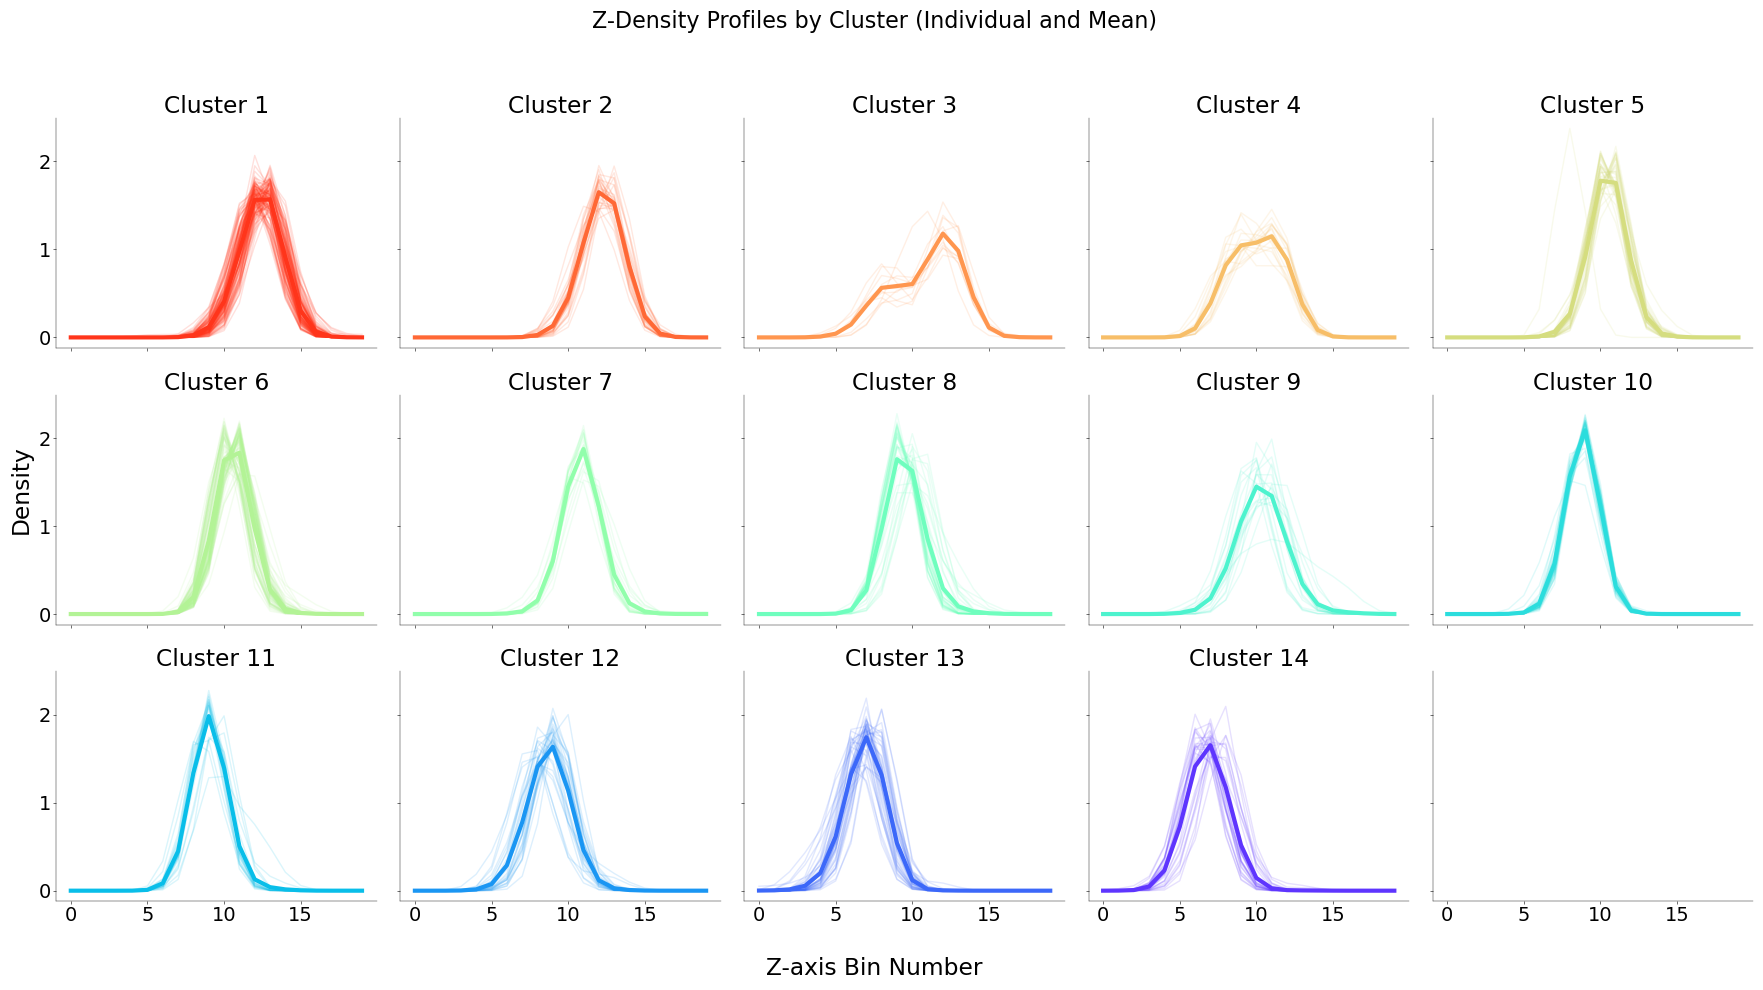

In [ ]:
# --------------------------------------------------------------------
# plot the Z-density maps and their means sorted by class label (1 pt)
# Note: make sure the clusters are comparable.
# -------------------------------------------------------------------
def plot_density_maps_corrected(dm_z: list, labels: pd.Series, colors: list) -> None:
    """
    Plots the z-density maps for all neurons and their means, sorted by class label.
    Args:
        dm_z (list): List of density map dictionaries.
        labels (pd.Series): Series containing cluster labels.
        colors (list): List of colors for each cluster.
    """
    # THE FIX IS HERE: Extract the array from the 'data' key of each dictionary.
    density_data_list = [item["data"] for item in dm_z]
    df = pd.DataFrame(density_data_list)
    df["cluster"] = labels.values

    # Get the unique, sorted cluster labels to iterate through
    unique_clusters = sorted(df["cluster"].unique())

    # Create a grid of subplots
    fig, axes = plt.subplots(3, 5, figsize=(18, 10), sharex=True, sharey=True)
    axes = axes.flatten()

    # Loop through each cluster and its corresponding subplot axis
    for i, cluster_id in enumerate(unique_clusters):
        if i >= len(axes) or i >= len(colors):
            break

        ax = axes[i]
        cluster_maps = df[df["cluster"] == cluster_id].drop("cluster", axis=1)
        # Plot all individual density maps for the cluster
        for row_idx in range(len(cluster_maps)):
            ax.plot(
                cluster_maps.iloc[row_idx].values,
                color=colors[i],
                alpha=0.15,
                linewidth=1,
            )

        # Calculate and plot the mean density map
        mean_density = cluster_maps.mean()
        ax.plot(mean_density.values, color=colors[i], alpha=1.0, linewidth=3)

        ax.set_title(f"Cluster {int(cluster_id)}")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # Add overall labels and title
    fig.supxlabel("Z-axis Bin Number")
    fig.supylabel("Density")
    fig.suptitle("Z-Density Profiles by Cluster (Individual and Mean)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_density_maps_corrected(dm_z, labels["cluster"], colors)

### Questions (1 pt)

1) What does the Z-density map tell you about the cell types? Can you identify a trend in the density maps?

**Answer:**

2) Which cluster(s) would you expect the cell from Task 1 to come from and why?

**Answer:**


## Task 4: 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

*Grading: 3 pts*

In [ ]:
from openTSNE import TSNE

# ----------------------------------------------------------------------
# Fit t-SNE with morphometric statistics and density maps (0.5 + 0.5 pt)
# Note that this can take a bit to run. (use perplexity=100
# and a random state of 17)
# ----------------------------------------------------------------------

density_data_list = [item["data"] for item in dm_z]

tsne_morpho = TSNE(
    perplexity=100,
    n_iter=1000,
    metric="euclidean",
    initialization="random",
    random_state=17,
)
embedding_morpho = tsne_morpho.fit(morphometric_data)
# Fit t-SNE with density maps
tsne_density = TSNE(
    perplexity=100,
    n_iter=1000,
    metric="euclidean",
    initialization="random",
    random_state=17,
)
embedding_density = tsne_density.fit(np.array(density_data_list))
# ----------------------------------------------------------------------

In [68]:
# Cache the t-SNE embeddings
import pickle

with open("tsne_embeddings.pkl", "wb") as f:
    pickle.dump((embedding_morpho, embedding_density), f)
# Load the cached t-SNE embeddings
with open("tsne_embeddings.pkl", "rb") as f:
    embedding_morpho, embedding_density = pickle.load(f)
# ----------------------------------------------------------------------

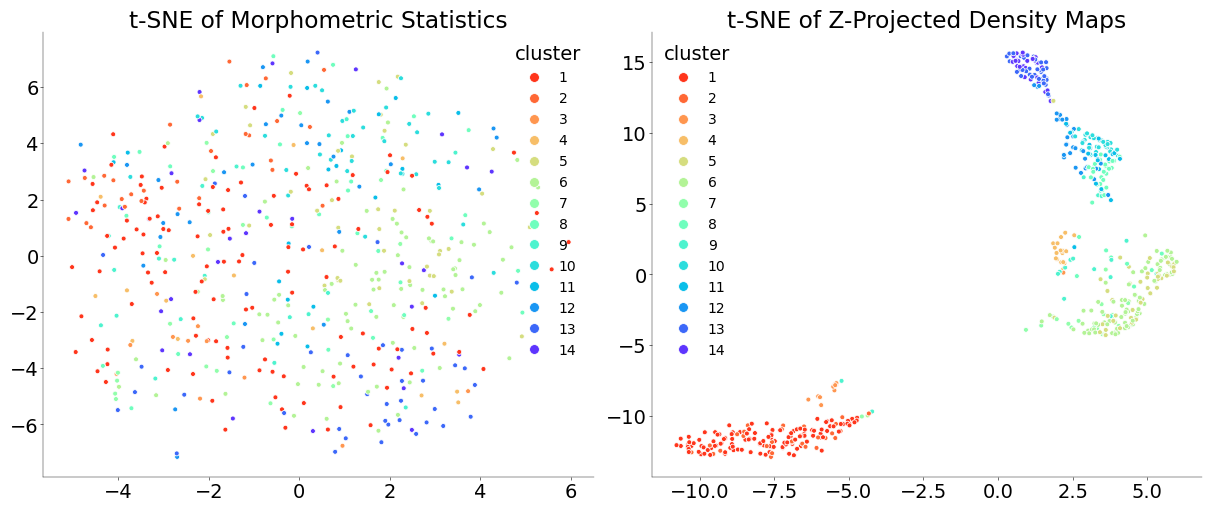

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained")

# ----------------------------------------------------------------------------
# plot tsne fits for both morpometric statistics and z-projected density maps.
# Color the points appropriately and answer the questions below. (2 pt)
# ----------------------------------------------------------------------------

# Plot t-SNE for morphometric statistics
sns.scatterplot(
    x=embedding_morpho[:, 0],
    y=embedding_morpho[:, 1],
    hue=labels["cluster"],
    palette=colors,
    ax=axes[0],
    s=50,
)
axes[0].set_title("t-SNE of Morphometric Statistics")
# Plot t-SNE for density maps
sns.scatterplot(
    x=embedding_density[:, 0],
    y=embedding_density[:, 1],
    hue=labels["cluster"],
    palette=colors,
    ax=axes[1],
    s=50,
)
axes[1].set_title("t-SNE of Z-Projected Density Maps")
plt.show()

### Questions:
1) Which representation produces the better clustering? Why could this be the case?

**Answer:**

2) What are the advantages of morphometric statistics over density maps 

**Answer:**

3) What are the advantages of density maps over morphometric statistics 

**Answer:**

## Task 5: Predicting the projection site

The relationship between neuronal morphology and functional specialization is well-established in neurobiology. Hence, we expect distinct functional domains within the thalamus to exhibit corresponding morphological signatures. In this analysis, we aim to predict the thalamic projection site (`labels['projection_site']`) of individual neurons based on their morphological characteristics. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?

You can use `LogisticRegressionCV` of the scikit-learn library directly. To understand the relevance of individual features plot the fitted linear coefficients. Note, since the classes are imbalanced make sure to report the balanced prediction accuracy.

*Grading: 2 pts*

In [99]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder


# -----------------------------------------------------------------------------
# Fit a logistic regressor to predict the projection site based on both feature
# representations and print the avg. prediction accuracy (1 pt)
# -----------------------------------------------------------------------------
def fit_logistic_regression(X: np.ndarray, y: pd.Series) -> float:
    """Fits a logistic regression model and returns the average accuracy.

    Args:
        X (np.ndarray): Feature matrix.
        y (pd.Series): Target labels.

    Returns:
        float: Average accuracy of the model.
    """
    model = LogisticRegressionCV(
        cv=5, max_iter=1000, random_state=17, scoring="balanced_accuracy"
    )

    scores = cross_val_score(model, X, y, cv=5, scoring="balanced_accuracy")

    # --- 4. Get the Coefficients (The Right Way) ---
    # To get a single set of coefficients for interpretation, fit the model on all the data
    model.fit(X, y)
    final_coefficients = model.coef_[0]

    return np.mean(scores), final_coefficients


le = LabelEncoder()
_encoded_projection_site = le.fit_transform(labels["projection_site"])

morpho_cv_score, morpho_coefficients = fit_logistic_regression(
    morphometric_data, _encoded_projection_site
)
print(f"Avg. Cross-Validated Balanced Accuracy (Morpho Stats): {morpho_cv_score:.4f}")

density_cv_score, density_coefficients = fit_logistic_regression(
    density_data_list, _encoded_projection_site
)
print(f"Avg. Cross-Validated Balanced Accuracy (Density Maps): {density_cv_score:.4f}")

Avg. Cross-Validated Balanced Accuracy (Morpho Stats): 0.6803
Avg. Cross-Validated Balanced Accuracy (Density Maps): 0.6073


While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

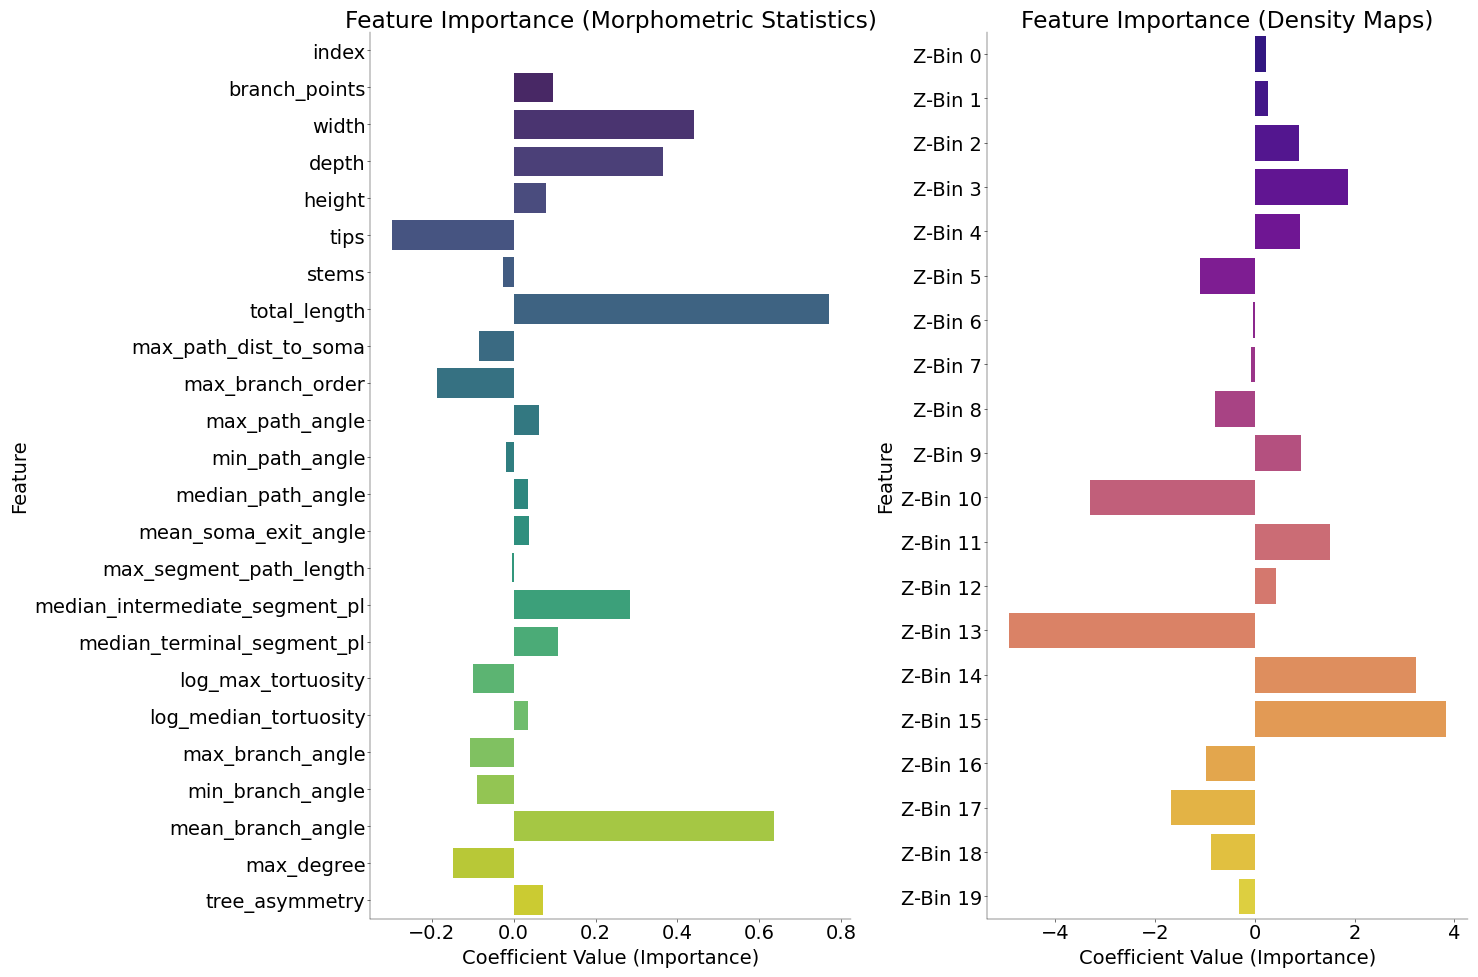

In [108]:
# ---------------------------------------------------------------------------
# Plot the fitted linear coefficients for both of the feature representations
# and answer the question below. (1 pt)
# ---------------------------------------------------------------------------

# Get the corresponding feature names for the plot
features_to_drop = [
    "avg_thickness",
    "max_thickness",
    "total_surface",
    "total_volume",
    "log_min_tortuosity",
]
feature_names_morpho = morphometric_statistics.drop(
    features_to_drop, axis=1
).columns.tolist()
X_density = np.array([item["data"] for item in dm_z])
feature_names_density = [f"Z-Bin {i}" for i in range(X_density.shape[1])]

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

sns.barplot(
    x=morpho_coefficients, y=feature_names_morpho, ax=axes[0], palette="viridis"
)
axes[0].set_title("Feature Importance (Morphometric Statistics)")
axes[0].set_xlabel("Coefficient Value (Importance)")
axes[0].set_ylabel("Feature")

# Plot coefficients for density maps
plt.subplot(1, 2, 2)
sns.barplot(
    x=density_coefficients, y=feature_names_density, ax=axes[1], palette="plasma"
)
axes[1].set_title("Feature Importance (Density Maps)")
axes[1].set_xlabel("Coefficient Value (Importance)")
axes[1].set_ylabel("Feature")


plt.tight_layout()
plt.show()

### Question:

1) Which morphometrics are informative on the projection site?

**Answer:**

## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)